# Overview 
This notebook covers: 
- Feature engineering 
    - Creating new features
    - Preprocessing the data 
    - Merging the datasets into one 
- Model training
    - XGBoost
    - Random Forest 
    - CatBoost
    - Hyperparameter Tuning
- Explainable Artificial Intelligence
    - Global Explanations
    - Local Explanations

# 1. Data preprocessing and feature engineering

In [81]:
# Importing libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# Ensuring reproducability
RANDOM_SEED = 2024
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Set pandas display options
pd.set_option('display.float_format', lambda x: f'{x:.2f}')
pd.set_option('display.max_columns', None)

# 1.1. Diet

In [82]:
# loading the diet dataset
diet = pd.read_csv("diet.csv")

#### Creating Age Group feature

In [83]:
# Creating categories for Age feature
bins = [0, 20, 30, 40, 50, 60, 70, 80, float('inf')]
labels = ["<20", "<30", "<40", "<50", "<60", "<70", "<80", "<90"]
diet['Age_Group'] = pd.cut(diet['Age'], bins=bins, labels=labels, right=False)
diet

,AuthorId,Diet,Age,Age_Group
0,10000120E,Vegetarian,46,<50
1,1000014D,Vegan,18,<20
2,1000015A,Vegetarian,58,<60
3,1000016E,Vegetarian,32,<40
4,1000027E,Vegan,61,<70
...,...,...,...,...
271902,999917E,Vegetarian,28,<30
271903,999936C,Omnivore,22,<30
271904,99993D,Vegetarian,58,<60
271905,99994A,Vegetarian,18,<20


In [84]:
# Changing the dtype to categorical for Age_Group and Diet
diet['Age_Group'] = diet['Age_Group'].astype('category')
diet['Diet'] = diet['Diet'].astype('category')


# 1.2. Recipes 

In [85]:
# loading the recipes dataset
recipes = pd.read_csv("recipes.csv", dtype={"RecipeId": str})

In [86]:
# Cleaning up the ingredients column 
def get_ingredient_list(parts):
    # Remove 'c(' and ')' from the string and split by ","
    parts_list = parts[2:-1].split('", "')
    # Strip unnecessary symbols from each element in the list
    parts_list = [ingredient.strip('"\\"') for ingredient in parts_list]
    
    return parts_list

# Function to add
def get_ing_list(row):
    return get_ingredient_list(row['RecipeIngredientParts'])

# creating a new column of an actual list
recipes["IngredientList"] = recipes.apply(get_ing_list, axis=1)
recipes.head(2)

,RecipeId,Name,CookTime,PrepTime,RecipeCategory,RecipeIngredientQuantities,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,IngredientList
0,73440,Bow Ties With Broccoli Pesto,0,1800,Other,"c(""\""6\"""", ""\""2\"""", ""\""1 1/2\"""", ""\""1/4\"""", ""\...","c(""\""hazelnuts\"""", ""\""broccoli florets\"""", ""\""...",241.30,10.10,1.20,0.00,13.10,31.80,2.30,1.40,6.70,9.00,NaN,"[hazelnuts, broccoli florets, fresh parsley le..."
1,365718,Cashew-chutney Rice,3600,600,Other,"c(""\""1\"""", ""\""3/4\"""", ""\""6\"""", ""\""5\"""", ""\""2\""...","c(""\""celery\"""", ""\""onion\"""", ""\""butter\"""", ""\""...",370.80,17.50,7.20,22.90,553.30,44.30,1.60,2.20,9.40,8.00,NaN,"[celery, onion, butter, chicken broth, long gr..."


#### Creating a feature RcipeCategory which includes options Vegan, Vegetarian, Omnivore + binary columns for Meat, Fish, Dairy, Egg, Vegan, Other depending on required ingredients for each recipe

In [87]:
# I will get the list of ingrediets for each recipe and based on them classify each recipe into vegan, vegetarian, or omnivore
IngredientList = recipes['IngredientList'].apply(lambda x: [ingredient.strip() for ingredient in x])
IngredientList.to_csv("IngredientList.csv", index=True)

In [88]:
# I used CHAT-GPT to categorize the recipes based on their ingredients and to create binary columns for Meat, Fish, Dairy, Egg, Vegan, and Other 
categories = pd.read_csv("Categorized_Ingredient_Lists_with_Binary_Columns.csv")
recipes[["Category", "Meat", "Fish", "Dairy", "Egg", "Vegan", "Other"]] = categories[["Category", "Meat", "Fish", "Dairy", "Egg", "Vegan", "Other"]]
recipes.head(2)

,RecipeId,Name,CookTime,PrepTime,RecipeCategory,RecipeIngredientQuantities,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,IngredientList,Category,Meat,Fish,Dairy,Egg,Vegan,Other
0,73440,Bow Ties With Broccoli Pesto,0,1800,Other,"c(""\""6\"""", ""\""2\"""", ""\""1 1/2\"""", ""\""1/4\"""", ""\...","c(""\""hazelnuts\"""", ""\""broccoli florets\"""", ""\""...",241.30,10.10,1.20,0.00,13.10,31.80,2.30,1.40,6.70,9.00,NaN,"[hazelnuts, broccoli florets, fresh parsley le...",Vegan,0,0,0,0,1,0
1,365718,Cashew-chutney Rice,3600,600,Other,"c(""\""1\"""", ""\""3/4\"""", ""\""6\"""", ""\""5\"""", ""\""2\""...","c(""\""celery\"""", ""\""onion\"""", ""\""butter\"""", ""\""...",370.80,17.50,7.20,22.90,553.30,44.30,1.60,2.20,9.40,8.00,NaN,"[celery, onion, butter, chicken broth, long gr...",Omnivore,1,0,1,0,0,0


#### Normalizing the Macronutrient to show the amount per 100 gr

In [89]:
# I estimated the yields of the recipes using Claude Sonnet 4.  
estYields = pd.read_csv('recipes_with_yield_estimates.csv', dtype={"RecipeId": str})

In [90]:
# adding estimated yields to the recipes dataframe   
recipes = recipes.merge(estYields[['RecipeId', 'EstimatedYieldGrams']], on='RecipeId', how='left')
recipes.head(2)


,RecipeId,Name,CookTime,PrepTime,RecipeCategory,RecipeIngredientQuantities,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,IngredientList,Category,Meat,Fish,Dairy,Egg,Vegan,Other,EstimatedYieldGrams
0,73440,Bow Ties With Broccoli Pesto,0,1800,Other,"c(""\""6\"""", ""\""2\"""", ""\""1 1/2\"""", ""\""1/4\"""", ""\...","c(""\""hazelnuts\"""", ""\""broccoli florets\"""", ""\""...",241.30,10.10,1.20,0.00,13.10,31.80,2.30,1.40,6.70,9.00,NaN,"[hazelnuts, broccoli florets, fresh parsley le...",Vegan,0,0,0,0,1,0,365.80
1,365718,Cashew-chutney Rice,3600,600,Other,"c(""\""1\"""", ""\""3/4\"""", ""\""6\"""", ""\""5\"""", ""\""2\""...","c(""\""celery\"""", ""\""onion\"""", ""\""butter\"""", ""\""...",370.80,17.50,7.20,22.90,553.30,44.30,1.60,2.20,9.40,8.00,NaN,"[celery, onion, butter, chicken broth, long gr...",Omnivore,1,0,1,0,0,0,405.20


In [91]:
# Normalizing Nutritional Information per 100g
macro_columns = [
    'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent',
    'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent'
]

# Calculating macros per 100g
for col in macro_columns:
    recipes[f'{col}_per_100g'] = recipes[col] / (recipes['EstimatedYieldGrams'] / 100)

recipes.head(2)

,RecipeId,Name,CookTime,PrepTime,RecipeCategory,RecipeIngredientQuantities,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,IngredientList,Category,Meat,Fish,Dairy,Egg,Vegan,Other,EstimatedYieldGrams,Calories_per_100g,FatContent_per_100g,SaturatedFatContent_per_100g,CholesterolContent_per_100g,SodiumContent_per_100g,CarbohydrateContent_per_100g,FiberContent_per_100g,SugarContent_per_100g,ProteinContent_per_100g
0,73440,Bow Ties With Broccoli Pesto,0,1800,Other,"c(""\""6\"""", ""\""2\"""", ""\""1 1/2\"""", ""\""1/4\"""", ""\...","c(""\""hazelnuts\"""", ""\""broccoli florets\"""", ""\""...",241.30,10.10,1.20,0.00,13.10,31.80,2.30,1.40,6.70,9.00,NaN,"[hazelnuts, broccoli florets, fresh parsley le...",Vegan,0,0,0,0,1,0,365.80,65.97,2.76,0.33,0.00,3.58,8.69,0.63,0.38,1.83
1,365718,Cashew-chutney Rice,3600,600,Other,"c(""\""1\"""", ""\""3/4\"""", ""\""6\"""", ""\""5\"""", ""\""2\""...","c(""\""celery\"""", ""\""onion\"""", ""\""butter\"""", ""\""...",370.80,17.50,7.20,22.90,553.30,44.30,1.60,2.20,9.40,8.00,NaN,"[celery, onion, butter, chicken broth, long gr...",Omnivore,1,0,1,0,0,0,405.20,91.51,4.32,1.78,5.65,136.55,10.93,0.39,0.54,2.32


#### Creating categories for macronutrient content: high and low

In [92]:
# Creating binary columns for nutritional thresholds
recipes['Calories_high'] = recipes['Calories_per_100g'].apply(lambda x: 1 if x >= 300 else 0)
recipes['Protein_high'] = recipes['ProteinContent_per_100g'].apply(lambda x: 1 if x >= 25 else 0)
recipes['Sugar_low'] = recipes['SugarContent_per_100g'].apply(lambda x: 1 if x <= 5 else 0)
recipes['Fat_low'] = recipes['FatContent_per_100g'].apply(lambda x: 1 if x <= 3.50 else 0)
recipes['Fiber_high'] = recipes['FiberContent_per_100g'].apply(lambda x: 1 if x >= 4.50 else 0)

#### Cleaning up the Recipes data frame

In [93]:
# Dropping unnecessary columns and preparing the final recipes DataFrame
recipes_ready = recipes.copy()
recipes_ready.drop(columns=["RecipeIngredientQuantities", "RecipeIngredientParts", 'IngredientList', 'Name', 'Other',
                            'RecipeYield', 'Calories', 'FatContent', 'SaturatedFatContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent',	'SugarContent',	'ProteinContent'], inplace=True) # dropped Other column because it has no information

# Converting categorical features to categorical dtype
def set_categorical_dtype(df, cat_columns):
    """
    Converts columns in cat_columns to 'category' dtype in the given DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to modify.
        cat_columns (list): List of column names to convert.
        
    Returns:
        pd.DataFrame: The DataFrame with updated dtypes.
    """
    for col in cat_columns:
        if col in df.columns:
            df[col] = df[col].astype('category')
    return df

cat_columns = ['RecipeCategory', 'Category', 'Meat', 'Fish', 'Dairy', 'Egg', 'Vegan', 'Calories_high', 'Protein_high', 'Sugar_low', 'Fat_low', 'Fiber_high']
recipes_ready = set_categorical_dtype(recipes_ready, cat_columns)

In [94]:
recipes_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75604 entries, 0 to 75603
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   RecipeId                      75604 non-null  object  
 1   CookTime                      75604 non-null  int64   
 2   PrepTime                      75604 non-null  int64   
 3   RecipeCategory                75604 non-null  category
 4   CholesterolContent            75604 non-null  float64 
 5   RecipeServings                48891 non-null  float64 
 6   Category                      75604 non-null  category
 7   Meat                          75604 non-null  category
 8   Fish                          75604 non-null  category
 9   Dairy                         75604 non-null  category
 10  Egg                           75604 non-null  category
 11  Vegan                         75604 non-null  category
 12  EstimatedYieldGrams           75604 non-null  

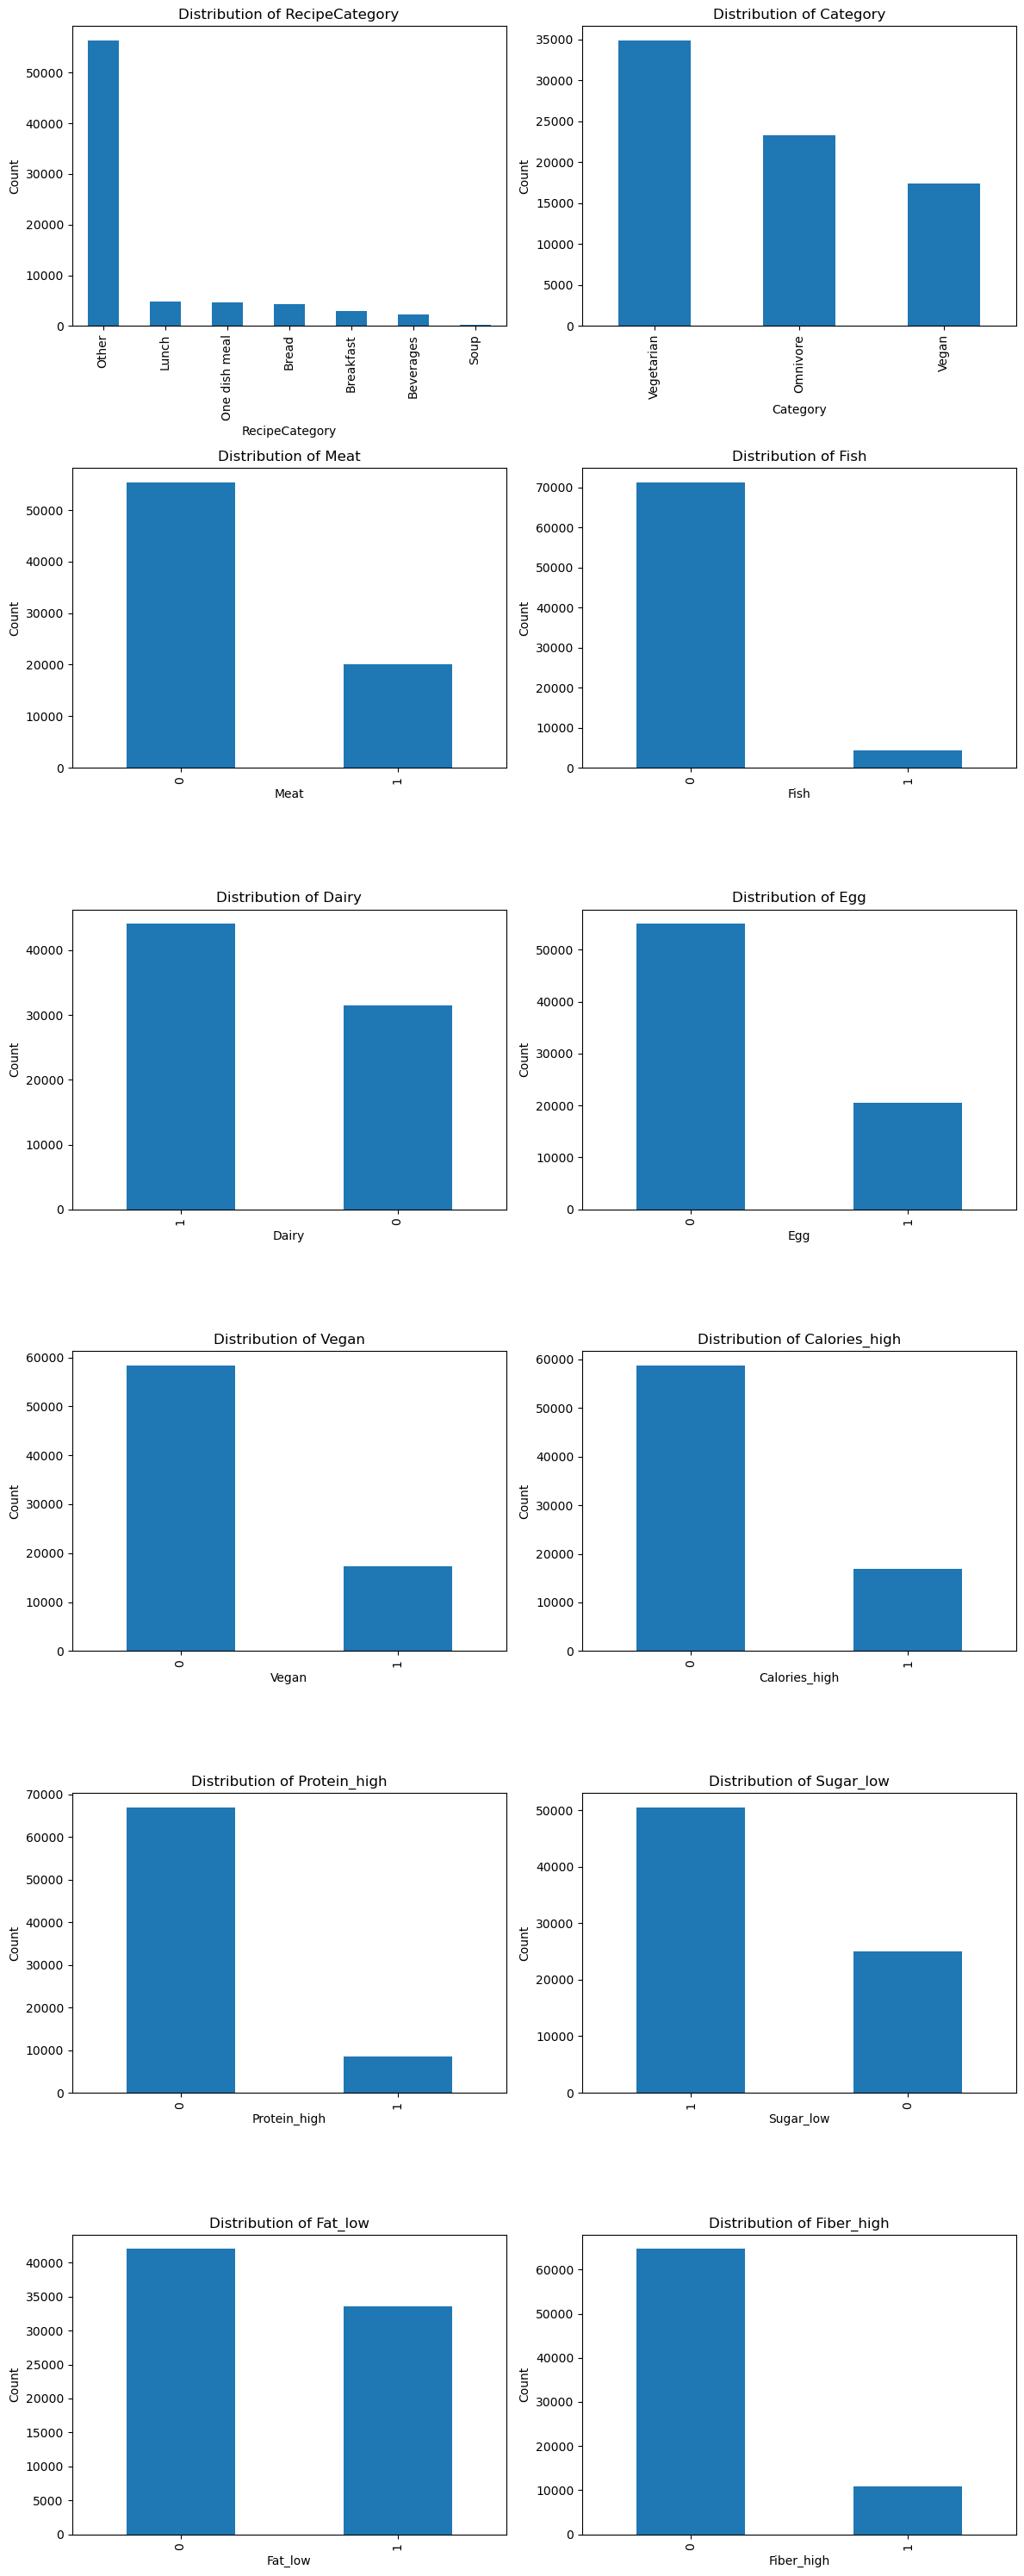

In [95]:
# Plot the distribution of each categorical column in cat_columns, 2 plots per row

import math

n_cols = 2
n_rows = math.ceil(len(cat_columns) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))

for idx, col in enumerate(cat_columns):
    row = idx // n_cols
    col_idx = idx % n_cols
    ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    recipes_ready[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

# Hide any unused subplots
for idx in range(len(cat_columns), n_rows * n_cols):
    row = idx // n_cols
    col_idx = idx % n_cols
    fig.delaxes(axes[row, col_idx] if n_rows > 1 else axes[col_idx])

plt.tight_layout()
plt.show()

# 1.3. Reviews

In [96]:
# loading the reviews dataset
reviews = pd.read_csv("reviews.csv", dtype={"Rating": "float64", "Like": "object", "TestSetId": "float64", "RecipeId": str})

In [97]:
# Map reviews to 0 and 1 as we need them in that format
reviews['Like'] = reviews['Like'].map({'FALSE': 0, 'TRUE': 1})

# 1.4 Requests

In [98]:
# loading the requests dataset
requests = pd.read_csv("requests.csv", dtype={"AuthorId": str, "RecipeId": str})

#### Standardizing the categorical features

In [99]:
# Mapping requests to binary values
requests['HighProtein'] = requests['HighProtein'].map({'Indifferent': 0, 'Yes': 1})
# turned it upside down
requests['LowSugar'] = requests['LowSugar'].map({'Indifferent': 0, '0': 1})

In [100]:
# Creating binary columns for nutritional thresholds in requests
requests_cat_cols = ['HighCalories', 'HighProtein', 'LowFat', 'LowSugar', 'HighFiber']
requests = set_categorical_dtype(requests, requests_cat_cols)

# 2.0. Merging the tables

In [101]:
# Merging all datasets into one DataFrame
merged = pd.merge(reviews, diet, on='AuthorId', how='left')
merged = pd.merge(merged, requests, on=['AuthorId', 'RecipeId'], how='left')
merged = pd.merge(merged, recipes_ready, on='RecipeId', how='left')
merged = pd.DataFrame(merged)
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140195 entries, 0 to 140194
Data columns (total 40 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   AuthorId                      140195 non-null  object  
 1   RecipeId                      140195 non-null  object  
 2   Rating                        77108 non-null   float64 
 3   Like                          97381 non-null   float64 
 4   TestSetId                     42814 non-null   float64 
 5   Diet                          140195 non-null  category
 6   Age                           140195 non-null  int64   
 7   Age_Group                     140195 non-null  category
 8   Time                          140195 non-null  float64 
 9   HighCalories                  140195 non-null  category
 10  HighProtein                   140195 non-null  category
 11  LowFat                        140195 non-null  category
 12  LowSugar                      

#### Creating a feature for time difference between reques and recipe

In [102]:
# combine CookTime with PrepTime and find the time_diff
merged['time_comb'] = merged['CookTime'] + merged['PrepTime']
merged['time_diff'] = merged['Time'] - merged['time_comb']

# Build feature whether the time exceeded or not
merged['TimeExceeded'] = merged['time_diff'].apply(lambda x: 1 if x < 10 else 0).astype('category')
merged[["Time", "CookTime", "PrepTime", "TimeExceeded", "time_comb", "time_diff"]]

#merged.drop(['CookTime', 'time_comb', 'Time', 'PrepTime', 'time_diff'], axis=1, inplace=True)

,Time,CookTime,PrepTime,TimeExceeded,time_comb,time_diff
0,2698.71,1500,1200,1,2700,-1.29
1,2399.69,1200,1200,1,2400,-0.31
2,2099.11,1200,900,1,2100,-0.89
3,1199.65,0,1200,1,1200,-0.35
4,2341.18,840,1500,1,2340,1.18
...,...,...,...,...,...,...
140190,3899.42,3000,900,1,3900,-0.58
140191,2402.37,1200,1200,1,2400,2.37
140192,5999.60,4800,1200,1,6000,-0.40
140193,480.23,360,120,1,480,0.23


In [103]:
# Converting specific columns to integer type
cols_to_int = [
    'HighCalories', 'Calories_high',
    'HighProtein', 'Protein_high',
    'LowSugar', 'Sugar_low',
    'LowFat', 'Fat_low',
    'HighFiber', 'Fiber_high'
]

In [104]:
for col in cols_to_int:
    if col in merged.columns:
        merged[col] = pd.to_numeric(merged[col], errors='coerce').astype('Int64')

#### Creating features for macronutrient match in request and recipe

In [105]:
#  Creating match columns for nutritional thresholds
merged["Calories_match"] = merged['HighCalories'] - merged['Calories_high'] # 0 or -1: match, 1: miss
merged['HighProtein'] = merged['HighProtein'].replace({'Indifferent':0, 'Yes':1})
merged["Protein_match"] = merged['HighProtein'] - merged['Protein_high'] # 0 or -1: match, 1: miss
merged['LowSugar'] = merged['LowSugar'].replace({'Indifferent':1, '0':0}) 
merged["Sugar_match"] = merged['LowSugar'] - merged['Sugar_low'] # 0, 1: match, -1 miss
merged["Fat_match"] = merged['LowFat'] - merged['Fat_low'] # 0 or -1: match, 1: miss
merged["Fiber_match"] = merged['HighFiber'] - merged['Fiber_high'] # 0 or -1: match, 1: miss

In [106]:
# Further categorizing the matches into 1 – match, 0 - mismatch 
merged['Calories_match'] = merged['Calories_match'].replace({0.0:1, -1.0:1, 1.0:0}).astype(int)
merged['Protein_match'] = merged['Protein_match'].replace({0:1, -1:1, 1:0})
merged['Sugar_match'] = merged['Sugar_match'].replace({0:1, -1:0})
merged['Fat_match'] = merged['Fat_match'].replace({0:1, -1:1, 1:0})
merged['Fiber_match'] = merged['Fiber_match'].replace({0:1, -1:1, 1:0})

In [107]:
# Displaying the first few rows of the match columns
merged[['Calories_match', 'Protein_match', 'Sugar_match', 'Fat_match', 'Fiber_match']].head()

,Calories_match,Protein_match,Sugar_match,Fat_match,Fiber_match
0,1,1,1,0,0
1,0,1,0,1,0
2,0,1,1,1,0
3,0,0,1,1,0
4,0,1,1,1,0


#### Creating a feture for dietary match

In [108]:
# generate dietary match column
merged["DietaryMatch"] = merged['Diet'].astype(str) + "_" + merged['Category'].astype(str)
merged[['DietaryMatch', 'Diet', 'Category']].head()

,DietaryMatch,Diet,Category
0,Omnivore_Omnivore,Omnivore,Omnivore
1,Omnivore_Omnivore,Omnivore,Omnivore
2,Omnivore_Omnivore,Omnivore,Omnivore
3,Omnivore_Omnivore,Omnivore,Omnivore
4,Omnivore_Omnivore,Omnivore,Omnivore


In [109]:
# checking the resulting DataFrame
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140195 entries, 0 to 140194
Data columns (total 49 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   AuthorId                      140195 non-null  object  
 1   RecipeId                      140195 non-null  object  
 2   Rating                        77108 non-null   float64 
 3   Like                          97381 non-null   float64 
 4   TestSetId                     42814 non-null   float64 
 5   Diet                          140195 non-null  category
 6   Age                           140195 non-null  int64   
 7   Age_Group                     140195 non-null  category
 8   Time                          140195 non-null  float64 
 9   HighCalories                  140195 non-null  Int64   
 10  HighProtein                   140195 non-null  Int64   
 11  LowFat                        140195 non-null  Int64   
 12  LowSugar                      

#### Dropping irrelevant columns and adjusting turning categorical feature to categorical data type 

In [110]:
# Dropping unnecessary columns
merged = merged.drop(columns=['RecipeId', 'AuthorId', 'Rating', 'TestSetId',  'RecipeServings'])

In [111]:
# Setting the categorical data types for specific columns
categorical_cols = ['Rating', 'Diet', 'HighCalories', 'HighProtein', 'LowFat', 'LowSugar', 'HighFiber', 'Category', 'Calories_high', 'Protein_high',
                    'Sugar_low', 'Fat_low', 'Fiber_high', 'Calories_match', 'Protein_match', 'Sugar_match', 'Fat_match', 'Fiber_match', 'DietaryMatch']
merged = set_categorical_dtype(merged, categorical_cols)
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140195 entries, 0 to 140194
Data columns (total 44 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   Like                          97381 non-null   float64 
 1   Diet                          140195 non-null  category
 2   Age                           140195 non-null  int64   
 3   Age_Group                     140195 non-null  category
 4   Time                          140195 non-null  float64 
 5   HighCalories                  140195 non-null  category
 6   HighProtein                   140195 non-null  category
 7   LowFat                        140195 non-null  category
 8   LowSugar                      140195 non-null  category
 9   HighFiber                     140195 non-null  category
 10  CookTime                      140195 non-null  int64   
 11  PrepTime                      140195 non-null  int64   
 12  RecipeCategory                

# 3. Model Training and Evaluation

In [112]:
# Subsetting the rows with the target variable 'Like' not null. 
# Rows with missing Like values were used as Test set for the assignment, but in this project, we can just drop them because we do not have ground truth for them.
merged = pd.DataFrame(merged)
merged = merged.dropna(subset=['Like'])
merged.head()

,Like,Diet,Age,Age_Group,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber,CookTime,PrepTime,RecipeCategory,CholesterolContent,Category,Meat,Fish,Dairy,Egg,Vegan,EstimatedYieldGrams,Calories_per_100g,FatContent_per_100g,SaturatedFatContent_per_100g,CholesterolContent_per_100g,SodiumContent_per_100g,CarbohydrateContent_per_100g,FiberContent_per_100g,SugarContent_per_100g,ProteinContent_per_100g,Calories_high,Protein_high,Sugar_low,Fat_low,Fiber_high,time_comb,time_diff,TimeExceeded,Calories_match,Protein_match,Sugar_match,Fat_match,Fiber_match,DietaryMatch
42814,0.00,Vegetarian,50,<60,119.02,0,0,0,0,1,0,120,Beverages,0.00,Vegan,0,0,0,0,1,77.10,179.90,0.00,0.00,0.00,0.78,0.00,0.00,0.00,0.00,0,0,1,1,0,120,-0.98,1,1,1,0,1,0,Vegetarian_Vegan
42815,0.00,Vegetarian,78,<80,1199.39,0,1,0,1,1,600,600,Other,33.90,Omnivore,1,1,0,0,0,523.60,75.57,3.67,0.86,6.47,136.40,7.26,0.15,0.82,3.11,0,0,1,0,0,1200,-0.61,1,1,0,1,1,0,Vegetarian_Omnivore
42816,0.00,Vegetarian,25,<30,362.15,0,1,0,0,1,60,300,Other,0.00,Vegan,0,0,0,0,1,400.00,31.40,3.38,0.47,0.00,0.15,0.47,0.10,0.10,0.05,0,0,1,1,0,360,2.15,1,1,0,0,1,0,Vegetarian_Vegan
42817,0.00,Vegetarian,25,<30,1198.96,0,1,0,1,1,0,1200,Breakfast,0.00,Vegan,0,0,0,0,1,171.70,926.09,28.54,4.19,0.00,67.44,140.77,40.42,9.14,40.13,1,1,0,0,1,1200,-1.04,1,1,1,1,1,1,Vegetarian_Vegan
42818,0.00,Vegetarian,25,<30,5400.04,1,0,0,1,0,3600,1800,Bread,110.00,Vegetarian,0,0,1,1,0,450.00,171.31,2.44,0.69,24.44,229.56,34.24,1.00,15.80,4.02,0,0,0,1,0,5400,0.04,1,0,1,1,1,1,Vegetarian_Vegetarian


In [113]:
# Splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X = merged.drop(columns=['Like'])
y = merged['Like'].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

In [114]:
# oversampling the records with likes
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
row_count = len(merged[merged['Like'] == 1])

oversampler = RandomOverSampler(sampling_strategy=0.9, random_state=RANDOM_SEED) # sampling_strategy = 0.9 shows the best results 
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

print(y_train.value_counts(normalize=True))
print(y_train.value_counts(normalize=False))
print(y_train.shape)


print(y_resampled.value_counts(normalize=True))
print(y_resampled.value_counts(normalize=False))
print(y_resampled.shape)

Like
0.00   0.87
1.00   0.13
Name: proportion, dtype: float64
Like
0.00    67602
1.00    10302
Name: count, dtype: int64
(77904,)
Like
0.00   0.53
1.00   0.47
Name: proportion, dtype: float64
Like
0.00    67602
1.00    60841
Name: count, dtype: int64
(128443,)


## 3.1. XGBoost

In [ ]:
from xgboost import XGBClassifier

# Fit XGBoost with categorical support
xgb_model = XGBClassifier(
    tree_method='hist',
    enable_categorical=True,
    random_state=RANDOM_SEED,
    eval_metric='logloss', 
)
xgb_model.fit(X_resampled, y_resampled)

# Example: predict on test set
y_pred = xgb_model.predict(X_test)

In [117]:
# Calculating balanced accuracy score 
from sklearn.metrics import balanced_accuracy_score
accuracy = balanced_accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# contingency table
ct = pd.crosstab(xgb_model.predict(X_test), y_test.values.ravel())
print(ct)

Accuracy: 0.8186142050839728
col_0   0.00  1.00
row_0             
0      14667   594
1       2234  1982


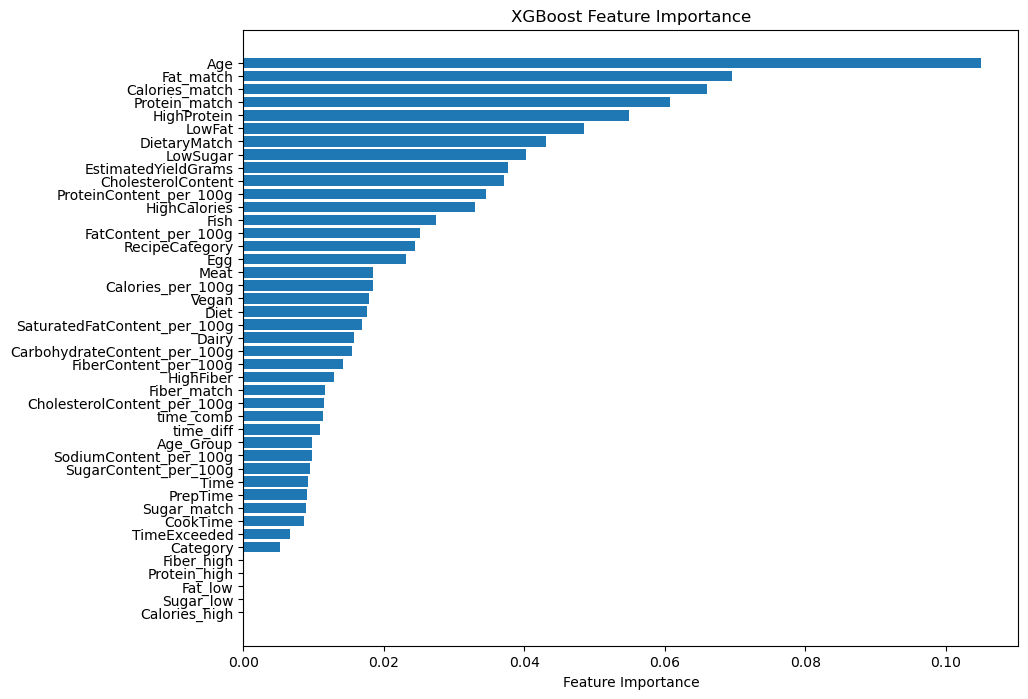

In [118]:
importances = xgb_model.feature_importances_
feature_names = X_resampled.columns

plt.figure(figsize=(10, 8))
sorted_idx = np.argsort(importances)[::-1]
plt.barh(range(len(importances)), importances[sorted_idx], align='center')
plt.yticks(range(len(importances)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

## 3.2. Random Forest

In [119]:
from sklearn.ensemble import RandomForestClassifier

# Identify categorical columns in X_train
categorical_features = X_resampled.select_dtypes(include=['category']).columns.tolist()

# Encode categorical features as integers for RandomForest
X_train_rf = X_resampled.copy()
X_test_rf = X_test.copy()
for col in categorical_features:
    X_train_rf[col] = X_train_rf[col].cat.codes
    X_test_rf[col] = X_test_rf[col].cat.codes

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model.fit(X_train_rf, y_resampled)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_rf)

In [120]:
# Calculating accuracy - trained on original train set
accuracy = balanced_accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)

# contingency table
ct = pd.crosstab(rf_model.predict(X_test_rf), y_test.values.ravel())
print(ct)

Accuracy: 0.6732974862562802
col_0   0.00  1.00
row_0             
0.00   16375  1603
1.00     526   973


## 3.3. CatBoost

In [122]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import balanced_accuracy_score

# Prepare categorical feature indices for CatBoost (column indices, not names)
cat_features_indices = [X_train.columns.get_loc(col) for col in categorical_features if col in X_train.columns]


# Create Pool objects for CatBoost
train_pool = Pool(X_resampled, y_resampled, cat_features=cat_features_indices)
test_pool = Pool(X_test, y_test, cat_features=cat_features_indices)

# Initialize and fit CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    cat_features=cat_features_indices,
    random_seed=RANDOM_SEED,
    depth=5,
    verbose=0
)
cb_model.fit(train_pool)

# Predict on test set
y_pred_cb = cb_model.predict(test_pool)


In [123]:
# Calculating accuracy
accuracy_cb = balanced_accuracy_score(y_test, y_pred_cb)
accuracy_xgb = balanced_accuracy_score(y_test, y_pred)
accuracy_rf = balanced_accuracy_score(y_test, y_pred_rf)

print("Accuracy CatBoost:", accuracy_cb)
print("Accuracy XGBoost:", accuracy_xgb)
print("Accuracy Random Forest:", accuracy_rf)


# contingency table
ct_cb = pd.crosstab(cb_model.predict(X_test), y_test.values.ravel())
print('Contingency Table CatBoost:\n', ct_cb)

ct_xgb = pd.crosstab(xgb_model.predict(X_test), y_test.values.ravel())
print('Contingency Table XGBoost:\n', ct_xgb)

ct_rf = pd.crosstab(rf_model.predict(X_test_rf), y_test.values.ravel())
print('Contingency Table Random Forest:\n', ct_rf)


Accuracy CatBoost: 0.8030918936583928
Accuracy XGBoost: 0.8186142050839728
Accuracy Random Forest: 0.6732974862562802
Contingency Table CatBoost:
 col_0   0.00  1.00
row_0             
0.00   13624   515
1.00    3277  2061
Contingency Table XGBoost:
 col_0   0.00  1.00
row_0             
0      14667   594
1       2234  1982
Contingency Table Random Forest:
 col_0   0.00  1.00
row_0             
0.00   16375  1603
1.00     526   973


## 3.4. Hyperparameter Tuning

### Both XGBoost and Catboost perform well. Generally CatBoost is considered to be a better model for categorical feature heavy data, as in our case. That's why we will use CatBoost for hyperparameter tuning.

In [124]:
# getting the list of default parameters
cb_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 100,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 1,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderT

In [125]:
# Define the model – again as plain CatBoostClassifier
cat_model = CatBoostClassifier(
    cat_features=cat_features_indices,
    random_seed=RANDOM_SEED,
    verbose=0
)
# Define hyperparameter search space
param_grid = {
    'iterations': [128, 256, 512],
    'learning_rate': [0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],  # tree depth
    'l2_leaf_reg': [3, 6, 9],
    'border_count': [32, 64, 128],  # number of splits for numerical features
    'random_strength': [1, 2, 3], 
    'grow_policy': ['SymmetricTree']
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from joblib import parallel_backend

search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='balanced_accuracy',             # matches your metric
    cv=5,
    random_state=RANDOM_SEED,
    n_jobs=2,                                # moderate parallelism
    verbose=1,
    error_score='raise'
)

with parallel_backend("loky", inner_max_num_threads=1):
    search.fit(
        X_train, y_train, # optimizing the hyperparameters on not oversampled data so that the model does not overfit the oversampled records
        eval_set=(X_test, y_test),
        early_stopping_rounds=50,
        verbose=False,
        use_best_model=True
    )

# Best model and parameters
print("Best Params:", search.best_params_)
print("Best Balanced Accuracy:", search.best_score_)

In [ ]:
search.best_params_

{'random_strength': 1,
 'learning_rate': 0.2,
 'l2_leaf_reg': 6,
 'iterations': 512,
 'grow_policy': 'SymmetricTree',
 'depth': 6,
 'border_count': 128}

In [129]:
# Predict on test set with the best model - repeating to have it defined with the best parameters
cat_features_indices = [X_train.columns.get_loc(col) for col in categorical_features if col in X_train.columns]

# Create Pool objects for CatBoost - repeating to have it defined with the best parameters
train_pool = Pool(X_resampled, y_resampled, cat_features=cat_features_indices)
test_pool = Pool(X_test, y_test, cat_features=cat_features_indices)

# Initialize and fit CatBoostClassifier
best_cb_model = CatBoostClassifier(
    random_strength=1,
    learning_rate=0.2,
    l2_leaf_reg=6,
    iterations=512,
    grow_policy='SymmetricTree',
    depth=6,
    border_count=128,
    cat_features=cat_features_indices,
    verbose=0
)

Fold 1 - Train Acc: 0.9208 | Val Acc: 0.8936
Fold 2 - Train Acc: 0.9203 | Val Acc: 0.8948
Fold 3 - Train Acc: 0.9218 | Val Acc: 0.8978
Fold 4 - Train Acc: 0.9214 | Val Acc: 0.9023
Fold 5 - Train Acc: 0.9225 | Val Acc: 0.8973


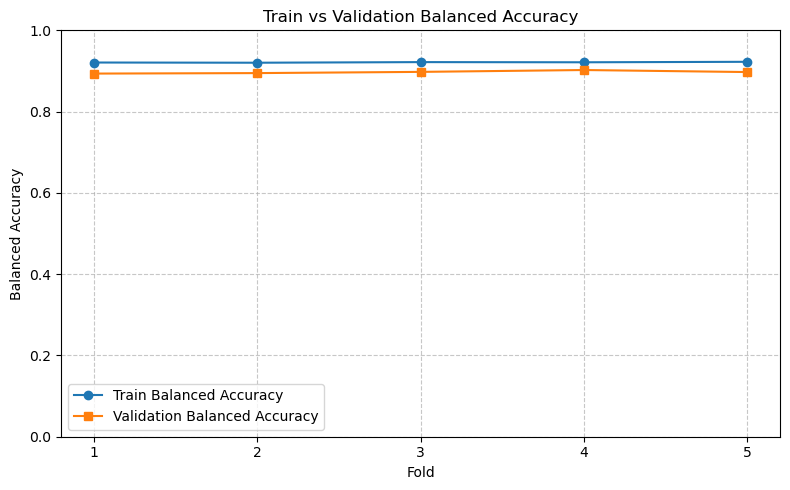

In [133]:
# Testing for overfitting using cross-validation
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

train_scores = []
val_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_resampled, y_resampled)):
    X_train_fold = X_resampled.iloc[train_idx]
    y_train_fold = y_resampled.iloc[train_idx]
    X_val_fold = X_resampled.iloc[val_idx]
    y_val_fold = y_resampled.iloc[val_idx]

    train_pool = Pool(X_train_fold, y_train_fold, cat_features=cat_features_indices)
    val_pool = Pool(X_val_fold, y_val_fold, cat_features=cat_features_indices)

    model = CatBoostClassifier(**best_cb_model.get_params())
    model.fit(train_pool)

    y_train_pred = model.predict(train_pool)
    y_val_pred = model.predict(val_pool)

    train_acc = balanced_accuracy_score(y_train_fold, y_train_pred)
    val_acc = balanced_accuracy_score(y_val_fold, y_val_pred)

    train_scores.append(train_acc)
    val_scores.append(val_acc)

    print(f"Fold {fold + 1} - Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# Plotting results
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), train_scores, label='Train Balanced Accuracy', marker='o')
plt.plot(range(1, 6), val_scores, label='Validation Balanced Accuracy', marker='s')
plt.xticks(range(1, 6))
plt.ylim(0, 1)
plt.xlabel('Fold')
plt.ylabel('Balanced Accuracy')
plt.title('Train vs Validation Balanced Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

### As it can be seen from the plot, the model is not overfitting the training data, but its performance on the test set in not improving with more iterations.

In [131]:
# Fitting the best CatBoost model on the entire training set
best_cb_model.fit(train_pool)
# Predicting on test set
y_pred_cb_best = best_cb_model.predict(test_pool)
# Calculating accuracy
accuracy_best = balanced_accuracy_score(y_test, y_pred_cb_best)

print("Accuracy Best CatBoost:", accuracy_best)

# contingency table
ct_cb_best = pd.crosstab(best_cb_model.predict(X_test), y_test.values.ravel())
print('Contingency Table CatBoost:\n', ct_cb_best)

Accuracy Best CatBoost: 0.8197304516510288
Contingency Table CatBoost:
 col_0   0.00  1.00
row_0             
0.00   14626   582
1.00    2275  1994


# 4.0 Explainable Artificial Intelligence

#### In this section I will dive deeper into the model and get additional insights. 
#### I will not cover the theory behind the SHAP values. However, I have covered it in [my article about XAI](https://medium.com/@asiljon-azimjonov/explainable-artificial-intelligence-telling-the-story-behind-the-prediction-deb376a82d5e) and provided some examples from another project. 

## 4.1. Global Explanations

In [49]:
import shap
# Create SHAP explainer instance
explainer = shap.Explainer(best_cb_model)

/var/folders/j1/6stxnx3x00qchv1fnj3gv0x80000gn/T/ipykernel_65410/1345082237.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, max_display=20)


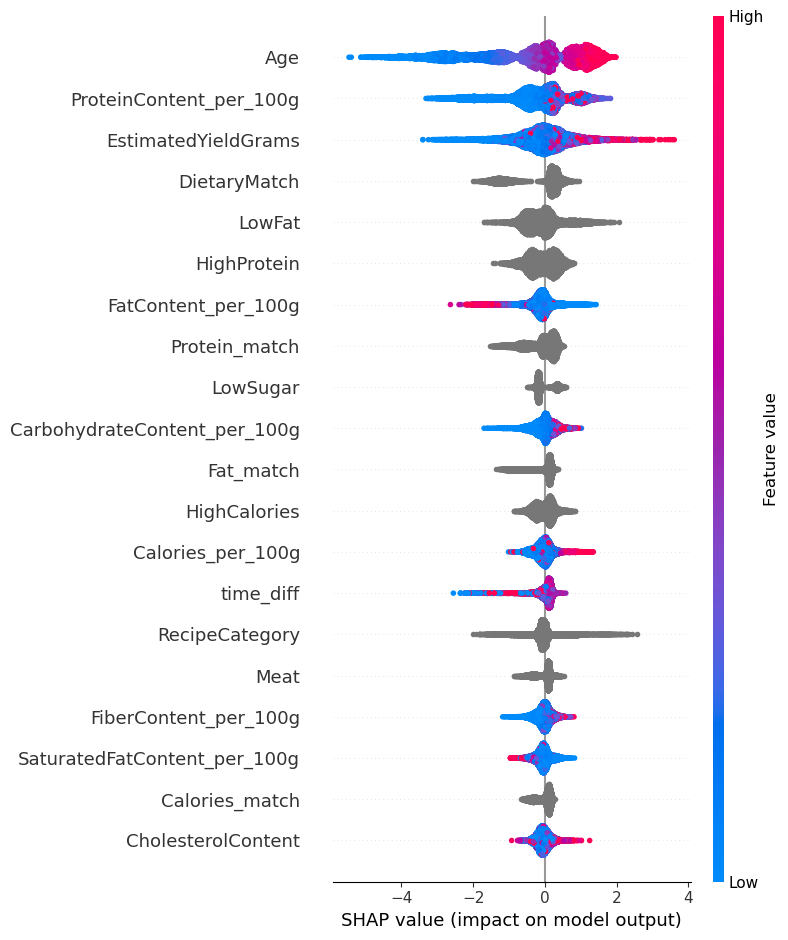

In [65]:
# Compute SHAP values
shap_values = explainer(X_test)
# Visualize summary plot
shap.summary_plot(shap_values, X_test, max_display=20)

#### The above presented plot shows the features in the order of importance.
#### Protein Age, Protein content per 100 gr, Estimated Yield, Dietary match, and Low Fat are 5 the most impactful features

---

#### Now let's explore feature interactions to get more insights into the way the model operates

#### First category in the DietMatch is the diet of the person. The second category is the category of the recipe generated by LLM. 
#### we can clearly see two groups:
- Collections of observations above 0 on the lest side scale (SHAP Value) – are people for whom the model predicted positive responce (Like) – when the recipe category matches the diet of the person. 
- Collection of observations below 0 – are people for whom the model predicted negative responce (Dislike) – when the category of the recipe matches the diet of the person. 
#### Here are some additional insights:
- Omnivores are more likely to like the recipes with high protein content, regardless if it is omnivore, vegetarian, or vegan recipe (red dots represents high protein content)
- Vegetarians and vegans are more likely to dislike omnivore recipes with high protein content
- The light grey histogram on the background shows the distribution of the data. Most of the generated recipes were requested by vegetarians – Vegetarian_Vegetarian having the most records


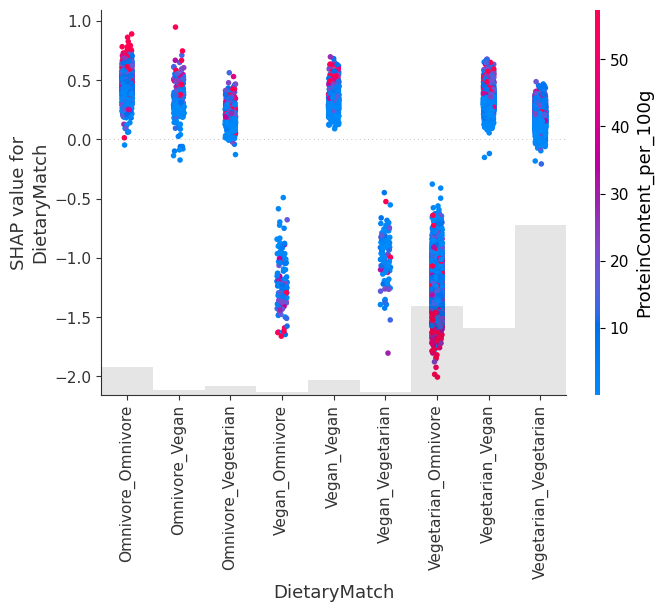

In [ ]:
shap.plots.scatter(shap_values[:,"DietaryMatch"], color = shap_values[:,"ProteinContent_per_100g"])

---

#### Let's look at the Age:
- higher the age, higher the probability that this person will like the recipe
- Fat content does not seem to have a significant influence on preferences of different age groups

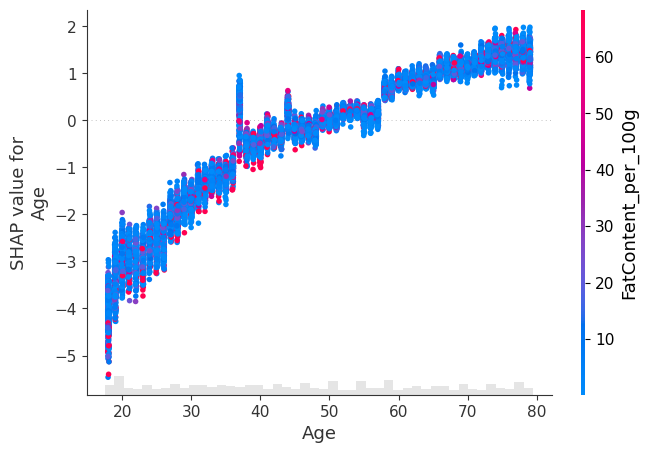

In [63]:
shap.plots.scatter(shap_values[:,"Age"], color = shap_values[:,"FatContent_per_100g"])

---

## 4.2. Local Explanations

#### Now let's look at individual predictions. 
#### On the following chart we can see that a person would like the recipe if it was higher in proteins and resulted in a bit larger amount of food. It should be noted that the features are listed in descending order based on importance. 

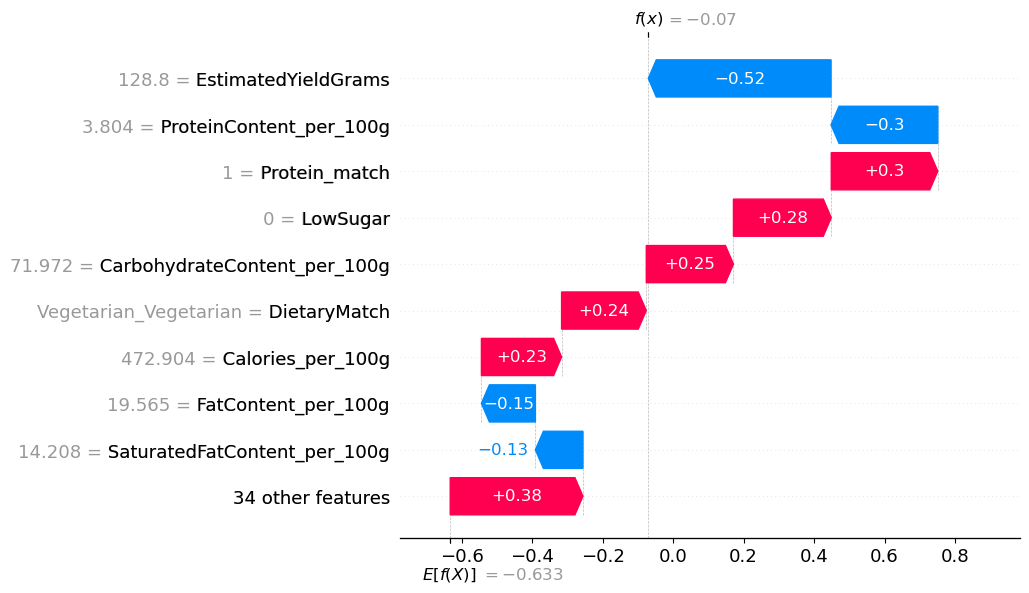

In [68]:
shap.plots.waterfall(shap_values[1])

#### Following chart shows an example of vegetarian customer getting omnivore recipe. As you can see, mismatch in diet is the main reason for dislike of this recipe.

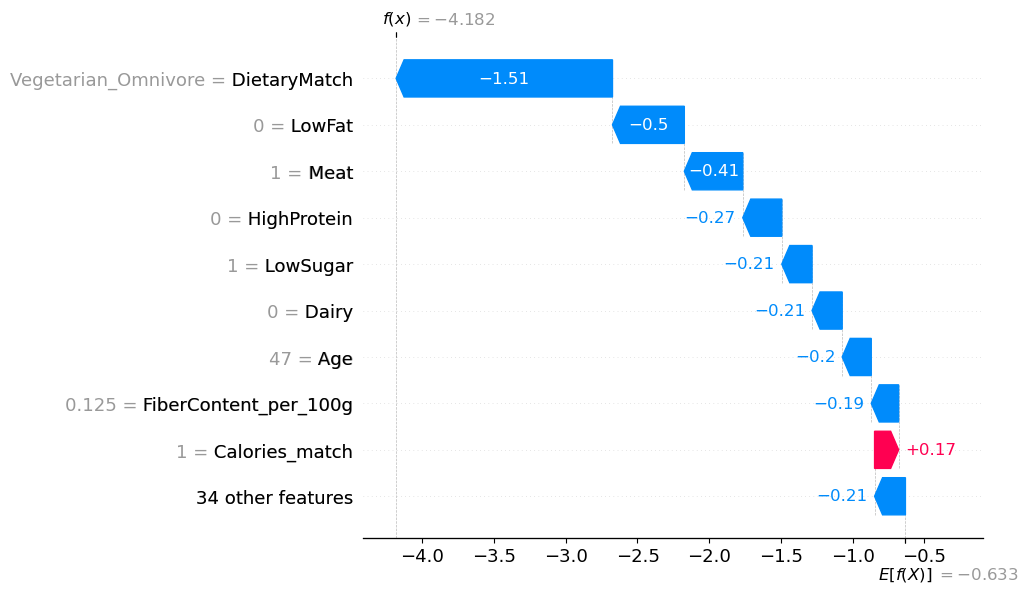

In [69]:
shap.plots.waterfall(shap_values[5])

# 5. Conclusions and remarks
Although the model accuracy was pretty good (>80%), it still can be improved by: 
- dealing with outliers in recipes, 
- improving the ratio of people with different diets
- perhaps, feature selection method can be applied to focus on the most important features
- hyperparameter tuning can be performed on XGBoost as well. Optimised CatBoost in the end performed almost like plain XGBoost, but I expected more from it. 